In [1]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438462 sha256=79f6a3f22748924260036145aad3f4389733f862e88399ee40bd2d19594763c4
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [21]:
%%writefile task6.py
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import timeit
from math import pi

start = timeit.default_timer()

comm = MPI.COMM_WORLD

size = comm.Get_size()
rank = comm.Get_rank()


N_total = 1000
my_n = int(N_total/size)

freq = 440 
duration = 1 #sec
fs = 2**14 # typical 

#t = np.linspace(0, duration, fs)

t=np.linspace(-20*2*pi, 20*2*pi, fs)
my_t = t[int(2**14/size)*rank:int(2**14/size)*(rank+1)]

y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*pi)**2/2/5**2)
y= y+ np.sin(4*t)*np.exp(-(t-7*2*pi)**2/2/10**2)


w=np.fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)

def get_specgram(cur_y, cur_range, nwindowsteps=1000):
    window_width=2*2*pi
    sp_list = []

    for i in cur_range:
        window_position=i*2*pi
        window_function=np.exp(-(t-window_position)**2/2/window_width**2)
        y_window=cur_y * window_function
        sp=np.fft.fft(y_window)
        sp_list.append(sp)
    
    #return abs(np.array(sp_list).T)**2
    return sp_list



total_range = np.linspace(-20,20,N_total)
my_range = total_range[rank*my_n:(rank+1)*my_n]

#print('total',total_range)


#print(my_range.shape)
#print('my_range',my_range)

my_sp = get_specgram(y, my_range)

#print(my_sp.shape)

sp_global = comm.gather(my_sp, root = 0)

if rank == 0:
  sp_global = abs(np.array(sp_global))**2
  print(sp_global.shape)
  sp_global = np.vstack(sp_global)

  print('reshape',sp_global.shape)
  
  plt.imshow(sp_global.T, aspect='auto', extent=[-20,20,0,2*max(w)])
  plt.ylim(0,6)
  plt.colorbar()
  plt.xlabel('t, cycles')
  plt.ylabel('Frequency, arb. units')
  plt.savefig('test2.png')

TIME = timeit.default_timer() - start

TIME_gen = comm.reduce(TIME, op=MPI.SUM, root = 0)
if rank == 0:
    print('final',TIME_gen/ size)

Overwriting task6.py


In [24]:
!mpirun --allow-run-as-root -n 3 python task6.py

(3, 333, 16384)
reshape (999, 16384)
final 3.226141087333341


Text(0, 0.5, 'Speedup')

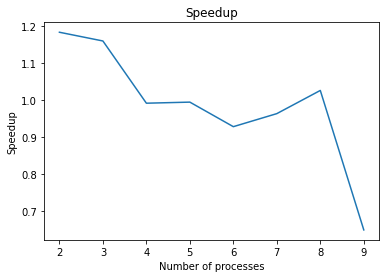

In [20]:
import numpy as np
import matplotlib.pyplot as plt
time_1_proc = 3.6023983390000467

proc_time = np.array([
    3.044009881999955,
    3.106013991666714,
    3.633085166749993,
    3.622408846799999,
    3.8814519553333944,
    3.739378887714273,
    3.510938839374972,
    5.551399426666724
])

plt.plot(1+np.array(range(1,proc_time.shape[0]+1)), time_1_proc/proc_time)
plt.title('Speedup')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')